<a href="https://colab.research.google.com/github/analystanand/3_3_puzzle/blob/main/Explaination_is_not_a_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explainability Is Not a Game

Reproducing the claims made by
https://cacm.acm.org/research/explainability-is-not-a-game/

1. Prepare the Dataset

Explaination of Dataset
Both **DT1 and DT2 are intentionally designed to be very similar, sharing the same fundamental logic for predicting the target class (class 1)**. This shared logic is the key to understanding the author's point about SHAP scores.

Here's the breakdown:

* **Both DTs use three features (x1, x2, x3) to predict a class label.**
* **The crucial rule in both DTs is: If feature 1 (x1) equals 1, the prediction is always class 1, regardless of the values of x2 and x3.**  This means that for any instance where x1 = 1, including the target instance ((1, 1, 2), 1),  features x2 and x3 have absolutely no influence on the prediction outcome.

**The only difference between DT1 and DT2 is in the specific class labels they assign when x1 equals 0.** This difference, while seemingly minor, affects how SHAP scores are calculated and contributes to the discrepancies the author highlights.  

* **DT1 (Figure 1a):** When x1 = 0, it assigns classes 0, 4, and 7 based on the combination of x2 and x3.
* **DT2 (Figure 1c):** When x1 = 0, it assigns classes 0, 2, 3, and 4 based on x2 and x3.

**The point is that the SHAP scores are sensitive to these different class assignments, even though they are irrelevant to the core logic of predicting class 1 when x1 = 1.**  This sensitivity leads to different interpretations of feature importance:

* **For DT1, SHAP scores misleadingly rank x2 and x3 as more important than x1, even though x1 is the only feature that actually matters for predicting class 1 in our target instance.**
* **For DT2, SHAP scores correctly identify x1 as the most important feature, but still assign non-zero importance to x2 and x3, despite their irrelevance.**

**This behavior illustrates the author's argument that SHAP scores, because they consider the global impact of features across all possible predictions, can provide a misleading picture of feature importance when the goal is to explain a specific prediction.**


In [28]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from shap import TreeExplainer
import pandas as pd

In [17]:
# Create a dictionary with the data
data = {
    'row': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'x1': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'x2': [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
    'x3': [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
    'k1': [0, 4, 0, 0, 7, 0, 1, 1, 1, 1, 1, 1],
    'k2': [0, 2, 0, 0, 3, 0, 1, 1, 1, 1, 1, 1]
}

# Create the DataFrame
base_df = pd.DataFrame(data)


In [18]:
base_df

,row,x1,x2,x3,k1,k2
0,1,0,0,0,0,0
1,2,0,0,1,4,2
2,3,0,0,2,0,0
3,4,0,1,0,0,0
4,5,0,1,1,7,3
5,6,0,1,2,0,0
6,7,1,0,0,1,1
7,8,1,0,1,1,1
8,9,1,0,2,1,1
9,10,1,1,0,1,1


In [25]:
# Step 1: Define the Parameterized Classifier Structure (Table 1)

def parameterized_classifier(x, sigma1, sigma2, sigma3, sigma4, sigma5, sigma6, alpha):
    x1, x2, x3 = x
    if x1 == 1:
        return alpha
    else:
        if x2 == 0 and x3 == 0:
            return sigma1
        elif x2 == 0 and x3 == 1:
            return sigma2
        elif x2 == 0 and x3 == 2:
            return sigma3
        elif x2 == 1 and x3 == 0:
            return sigma4
        elif x2 == 1 and x3 == 1:
            return sigma5
        elif x2 == 1 and x3 == 2:
            return sigma6


In [26]:
# Step 2: Create Decision Trees DT1 and DT2

# DT1 Parameters (Figure 1a)
alpha_dt1 = 1
sigma1_dt1 = sigma3_dt1 = sigma4_dt1 = sigma6_dt1 = 0
sigma2_dt1 = 4
sigma5_dt1 = 7

# DT2 Parameters (Figure 1c)
alpha_dt2 = 1
sigma1_dt2 = sigma3_dt2 = sigma4_dt2 = sigma6_dt2 = 0
sigma2_dt2 = 2
sigma5_dt2 = 3

In [59]:
# Create training data based on the parameterized classifier
X = np.array([[x1, x2, x3] for x1 in range(2) for x2 in range(2) for x3 in range(3)])
y_dt1 = np.array([parameterized_classifier(x, sigma1_dt1, sigma2_dt1, sigma3_dt1, sigma4_dt1, sigma5_dt1, sigma6_dt1, alpha_dt1) for x in X])
y_dt2 = np.array([parameterized_classifier(x, sigma1_dt2, sigma2_dt2, sigma3_dt2, sigma4_dt2, sigma5_dt2, sigma6_dt2, alpha_dt2) for x in X])

[link text](https://)

In [60]:
# Train Decision Tree Classifiers
dt1 = DecisionTreeClassifier()
dt1.fit(X, y_dt1)

dt2 = DecisionTreeClassifier()
dt2.fit(X, y_dt2)


DecisionTreeClassifier()

In [61]:

# Step 3: Calculate SHAP Scores for All Instances

# Create SHAP explainers
explainer_dt1 = TreeExplainer(dt1)
shap_values_dt1 = explainer_dt1.shap_values(X)

explainer_dt2 = TreeExplainer(dt2)
shap_values_dt2 = explainer_dt2.shap_values(X)

IndexError: index 3 is out of bounds for axis 1 with size 3

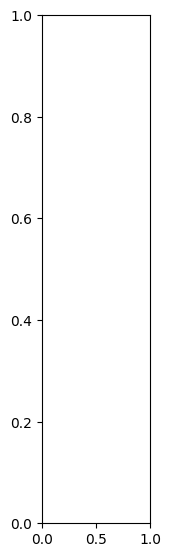

In [62]:
# Step 4: Plot SHAP Values

# Plot for DT1
shap.summary_plot(shap_values_dt1, X, feature_names=['x1', 'x2', 'x3'], title="DT1 SHAP Values")
plt.show()

# Plot for DT2
shap.summary_plot(shap_values_dt2, X, feature_names=['x1', 'x2', 'x3'], title="DT2 SHAP Values")
plt.show()

Explanation:
1.
SHAP Score Calculation for All Instances: The shap_values function is now called with the entire feature matrix X, resulting in SHAP values for all instances.
2.
Plotting: The shap.summary_plot function is used to generate a visual representation of the SHAP values. This plot will show:
◦
Feature importance: The features are ranked by their average absolute SHAP value, indicating their overall impact on the model's predictions.
◦
SHAP value distribution: For each feature, the plot displays how the SHAP values are distributed, allowing you to see the range and direction of the feature's influence.
◦
Feature value impact: The color of the points on the plot represents the value of the corresponding feature, helping you understand how different feature values contribute to the prediction.
Analysis:
The generated plots will visually demonstrate the claims made in the paper:
•
For DT1, the plot might show features x2 and x3 having a larger impact than x1, despite x1 being the sole determinant of class 1. This visually highlights the misleading nature of SHAP scores in this case.
•
For DT2, the plot should correctly show x1 as the most important feature. However, it might still indicate some non-zero influence from x2 and x3, further emphasizing the point that SHAP scores can overestimate the importance of irrelevant features.
By analyzing these plots, you can gain a deeper understanding of the potential issues with SHAP scores and the importance of considering alternative explanation methods for a more comprehensive interpretation of feature importance.